# Predicting maimai DX player map achievement scores

In [1]:
RANDOM_STATE = 42

In [2]:
%matplotlib inline
from pathlib import Path

import numpy as np
import pandas as pd
import rich
import scipy
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler

pd.set_option("display.max_columns", None)

In [3]:
# Loading the data
maimai_path = Path("maimai.csv")
bpm_path = Path("bpm.csv")

maimai_df = pd.read_csv(maimai_path)
bpm_df = pd.read_csv(bpm_path)

In [4]:
maimai_df

,Song,Genre,Version,Chart,Difficulty,Level,Achv,Rank,FC/AP,Sync,DX ✦,DX %,DX Score,Chart Constant
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23%,AAA,FC,SYNC,0,75.40%,570/756,?
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63%,AAA,-,SYNC,0,74.20%,766/1032,?
2,INTERNET YAMERO,POPS＆ANIME,BUDDiES PLUS,DX,ADVANCED,7+,96.34%,AAA,-,SYNC,0,73.20%,854/1167,7.8
3,INTERNET OVERDOSE,POPS＆ANIME,FESTiVAL,DX,ADVANCED,7,96.11%,AAA,-,SYNC,0,76.80%,820/1068,7.5
4,廻廻奇譚,POPS＆ANIME,UNiVERSE,DX,ADVANCED,7,97.65%,S,-,SYNC,0,79.00%,886/1122,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,Sweets×Sweets,maimai,maimai,STD,MASTER,11,96.53%,AAA,-,-,0,79.20%,920/1161,11.4
461,ネコ日和。,maimai,maimai,STD,MASTER,12+,98.72%,S+,FC,-,0,83.60%,868/1038,12.6
462,STARTLINER,オンゲキ＆CHUNITHM,maimaiでらっくす,DX,MASTER,11+,100.21%,SSS,FC,SYNC,1,90.00%,1406/1563,11.8
463,STARRED HEART,オンゲキ＆CHUNITHM,FESTiVAL PLUS,DX,MASTER,12,91.32%,AA,-,SYNC,0,77.00%,1114/1446,12.5


In [5]:
bpm_df

,songId,bpm,releaseDate
0,"""411Ψ892""",184.0,2023-02-03
1,#狂った民族２ PRAVARGYAZOOQA,170.0,2022-11-18
2,+♂,180.0,2015-12-09
3,-OutsideR:RequieM-,181.0,2019-03-08
4,1000年生きてる,100.0,2023-09-14
...,...,...,...
1346,頓珍漢の宴,145.0,2016-04-07
1347,天火明命,155.0,2017-05-23
1348,ミラクルポップ☆アドベンチャー!!!!!,180.0,2024-07-05
1349,フォルテシモBELL,121.0,2017-02-07


In [6]:
# Merging datasets
maimai_df.rename(columns={"Song": "songId"}, inplace=True)
merged_df = maimai_df.merge(bpm_df, on="songId", how="left")
print(f"Duplicated: {merged_df.duplicated().sum()}")
merged_df.head()

Duplicated: 0


,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,FC/AP,Sync,DX ✦,DX %,DX Score,Chart Constant,bpm,releaseDate
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23%,AAA,FC,SYNC,0,75.40%,570/756,?,211.0,2022-02-10
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63%,AAA,-,SYNC,0,74.20%,766/1032,?,88.0,2024-02-29
2,INTERNET YAMERO,POPS＆ANIME,BUDDiES PLUS,DX,ADVANCED,7+,96.34%,AAA,-,SYNC,0,73.20%,854/1167,7.8,185.0,2024-03-21
3,INTERNET OVERDOSE,POPS＆ANIME,FESTiVAL,DX,ADVANCED,7,96.11%,AAA,-,SYNC,0,76.80%,820/1068,7.5,163.0,2023-03-23
4,廻廻奇譚,POPS＆ANIME,UNiVERSE,DX,ADVANCED,7,97.65%,S,-,SYNC,0,79.00%,886/1122,7.5,185.0,2021-09-16


In [7]:
# Clean up unnecessary columns
merged_df.drop(columns=["FC/AP", "Sync", "DX ✦", "DX %"], inplace=True)

# Expose missing values
merged_df["Chart Constant"] = pd.to_numeric(
    merged_df["Chart Constant"], errors="coerce"
)

In [8]:
# convert releaseDate to numerical values
merged_df["releaseDate"] = pd.to_datetime(merged_df["releaseDate"], errors="coerce")
merged_df["releaseDate"] = (
    merged_df["releaseDate"] - merged_df["releaseDate"].min()
).dt.days
merged_df.head(3)

,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23%,AAA,570/756,NaN,211.0,3501.0
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63%,AAA,766/1032,NaN,88.0,4250.0
2,INTERNET YAMERO,POPS＆ANIME,BUDDiES PLUS,DX,ADVANCED,7+,96.34%,AAA,854/1167,7.8,185.0,4271.0


In [9]:
print(f"\nTotal rows with missing values: {merged_df.isna().any(axis=1).sum()}")
print("Rows with missing values:")
merged_df[merged_df.isna().any(axis=1)]


Total rows with missing values: 13
Rows with missing values:


,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23%,AAA,570/756,NaN,211.0,3501.0
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63%,AAA,766/1032,NaN,88.0,4250.0
5,さくゆいたいそう,POPS＆ANIME,BUDDiES,DX,ADVANCED,6+,99.26%,SS,829/1005,6.8,NaN,NaN
89,前前前世,POPS＆ANIME,MURASAKi PLUS,STD,EXPERT,9,97.21%,S,1111/1395,NaN,190.0,1807.0
97,さくゆいたいそう,POPS＆ANIME,BUDDiES,DX,EXPERT,9+,99.46%,SS,1422/1614,9.7,NaN,NaN
105,ヒトガタ,POPS＆ANIME,UNiVERSE PLUS,DX,EXPERT,10+,99.78%,SS+,1463/1650,10.8,NaN,NaN
189,ラグトレイン,niconico＆VOCALOID™,UNiVERSE,DX,EXPERT,9+,96.85%,AAA,1280/1608,9.8,NaN,NaN
218,Ultimate taste,東方Project,PRiSM (beta),DX,EXPERT,11,99.97%,SS+,1547/1785,11.0,NaN,NaN
279,分解収束テイル,maimai,FESTiVAL,DX,EXPERT,11,100.21%,SSS,1757/2007,11.0,NaN,NaN
284,"False Amber (from the Black Bazaar, Or by A Ke...",maimai,?,DX,EXPERT,13,90.59%,AA,1662/2424,NaN,NaN,NaN


In [10]:
# Fill missing Chart Constant values based on Level
level_mapping = merged_df.groupby("Level")["Chart Constant"].median()
print(level_mapping)

merged_df.fillna(
    {"Chart Constant": merged_df["Level"].map(level_mapping)}, inplace=True
)

print(
    f"\nRemaining missing Chart Constant values: {merged_df['Chart Constant'].isna().sum()}"
)
merged_df[["Level", "Chart Constant"]].head(10)

Level
10     10.20
10+    10.70
11     11.20
11+    11.80
12     12.35
12+    12.80
13     13.00
6        NaN
6+      6.80
7       7.35
7+      7.80
8       8.20
8+      8.70
9       9.30
9+      9.80
Name: Chart Constant, dtype: float64

Remaining missing Chart Constant values: 1


,Level,Chart Constant
0,6,NaN
1,7,7.35
2,7+,7.80
3,7,7.50
4,7,7.50
5,6+,6.80
6,7+,7.70
7,7,7.50
8,7,7.00
9,7+,7.90


In [11]:
# Simply map Level "6" -> 6.2, "6+" -> 6.8 for remaining missing values


def map_level_to_constant(level):
    if isinstance(level, str) and level.endswith("+"):
        return float(level[:-1]) + 0.8
    else:
        try:
            return float(level) + 0.2
        except ValueError:
            return None


merged_df["Chart Constant"] = merged_df.apply(
    lambda row: (
        map_level_to_constant(row["Level"])
        if pd.isna(row["Chart Constant"])
        else row["Chart Constant"]
    ),
    axis=1,
)

print(
    f"\nRemaining missing Chart Constant values: {merged_df['Chart Constant'].isna().sum()}"
)
merged_df[["Level", "Chart Constant"]].head(10)


Remaining missing Chart Constant values: 0


,Level,Chart Constant
0,6,6.20
1,7,7.35
2,7+,7.80
3,7,7.50
4,7,7.50
5,6+,6.80
6,7+,7.70
7,7,7.50
8,7,7.00
9,7+,7.90


In [12]:
# Drop easy charts
# merged_df = merged_df[merged_df["Chart Constant"] >= 10.5]

In [13]:
merged_df["DX Score"] = (
    merged_df["DX Score"].astype(str).str.split("/").str[1].astype(int)
)
merged_df.head(3)

,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23%,AAA,756,6.20,211.0,3501.0
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63%,AAA,1032,7.35,88.0,4250.0
2,INTERNET YAMERO,POPS＆ANIME,BUDDiES PLUS,DX,ADVANCED,7+,96.34%,AAA,1167,7.80,185.0,4271.0


In [14]:
# Remove the % suffix from the "Achv" column and convert it to float
merged_df["Achv"] = merged_df["Achv"].str.rstrip("%").astype(float)
merged_df.head(5)

,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23,AAA,756,6.20,211.0,3501.0
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63,AAA,1032,7.35,88.0,4250.0
2,INTERNET YAMERO,POPS＆ANIME,BUDDiES PLUS,DX,ADVANCED,7+,96.34,AAA,1167,7.80,185.0,4271.0
3,INTERNET OVERDOSE,POPS＆ANIME,FESTiVAL,DX,ADVANCED,7,96.11,AAA,1068,7.50,163.0,3907.0
4,廻廻奇譚,POPS＆ANIME,UNiVERSE,DX,ADVANCED,7,97.65,S,1122,7.50,185.0,3354.0


In [15]:
# display lowest Achv
merged_df.nsmallest(10, "Achv")

,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
176,グリーンライツ・セレナーデ,niconico＆VOCALOID™,maimaiでらっくす,DX,EXPERT,10,66.53,B,1839,10.3,200.0,2598.0
138,バグ,niconico＆VOCALOID™,BUDDiES,DX,EXPERT,10,69.89,B,1854,10.2,186.0,4082.0
320,炎歌 -ほむらうた-,maimai,BUDDiES PLUS,DX,EXPERT,9+,81.31,A,1017,9.8,108.0,286.0
41,FEEL the BEATS,maimai,PiNK,STD,ADVANCED,8+,83.66,A,1485,8.6,166.0,1380.0
354,Fragrance,maimai,maimai PLUS,STD,EXPERT,12+,86.69,A,882,12.7,180.0,246.0
147,セカイはまだ始まってすらいない,niconico＆VOCALOID™,FESTiVAL,DX,EXPERT,8+,88.27,A,1134,8.7,138.0,3383.0
342,Cryptarithm,maimai,PRiSM (beta),DX,EXPERT,13,88.38,A,2109,13.0,175.0,4475.0
357,ViRTUS,maimai,FESTiVAL,DX,EXPERT,13,88.97,A,2139,13.2,225.0,3886.0
415,はんぶんこ,POPS＆ANIME,FESTiVAL PLUS,DX,MASTER,12+,89.61,A,1131,12.9,124.0,4027.0
410,INTERNET OVERDOSE,POPS＆ANIME,FESTiVAL,DX,MASTER,13,89.85,A,2466,13.5,163.0,3907.0


In [16]:
# drop Achv outliners
merged_df = merged_df[(merged_df["Achv"] >= 85)]

In [17]:
# song map metrics
songs_df = Path("songs.csv")
songs_df = pd.read_csv(songs_df)
songs_df.head()

,songId,type,difficulty,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner
0,"""411Ψ892""",dx,basic,179.0,15.0,4.0,21.0,8.0,227,-
1,"""411Ψ892""",dx,advanced,298.0,31.0,12.0,31.0,10.0,382,-
2,"""411Ψ892""",dx,expert,416.0,53.0,52.0,25.0,85.0,631,ロシェ@ペンギン
3,"""411Ψ892""",dx,master,664.0,53.0,86.0,39.0,103.0,945,サファ太 vs じゃこレモン
4,#狂った民族２ PRAVARGYAZOOQA,dx,basic,172.0,10.0,10.0,8.0,44.0,244,-


In [18]:
songs_df["songId"] = songs_df["songId"].str.replace('"', "")

merged_df.rename(columns={"Chart": "type", "Difficulty": "difficulty"}, inplace=True)
merged_df["type"] = merged_df["type"].str.lower()
merged_df["difficulty"] = merged_df["difficulty"].str.lower()

merged_df = merged_df.merge(
    songs_df, on=["songId", "type", "difficulty"], how="left", copy=False
)

In [19]:
# Check new dataset for missing values
print(f"\nTotal rows with missing values: {merged_df.isna().any(axis=1).sum()}")
print("Rows with missing values:")
merged_df[merged_df.isna().any(axis=1)]


Total rows with missing values: 165
Rows with missing values:


,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner
0,躯樹の墓守,maimai,UNiVERSE,dx,basic,6,94.23,AAA,756,6.2,211.0,3501.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,廻廻奇譚,POPS＆ANIME,UNiVERSE,dx,advanced,7,97.65,S,1122,7.5,185.0,3354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,さくゆいたいそう,POPS＆ANIME,BUDDiES,dx,advanced,6+,99.26,SS,1005,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,偉大なる悪魔は実は大天使パトラちゃん様なのだ！,POPS＆ANIME,BUDDiES PLUS,dx,advanced,7+,98.50,S+,1164,7.7,195.0,4419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,過去を喰らう,POPS＆ANIME,BUDDiES PLUS,dx,advanced,7,100.39,SSS,1089,7.5,187.0,4271.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,りばーぶ,maimai,PiNK,std,master,11,96.91,AAA,1410,11.4,120.0,1246.0,353.0,6.0,98.0,NaN,13.0,470.0,rioN
455,超常マイマイン,maimai,maimaiでらっくす,dx,master,12+,95.92,AAA,2958,12.7,178.0,2556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456,Sweets×Sweets,maimai,maimai,std,master,11,96.53,AAA,1161,11.4,132.0,0.0,343.0,23.0,12.0,NaN,9.0,387.0,maimai TEAM
457,ネコ日和。,maimai,maimai,std,master,12+,98.72,S+,1038,12.6,171.0,0.0,283.0,36.0,11.0,NaN,16.0,346.0,ニャイン


In [20]:
note_count_columns = [
    "noteCounts.tap",
    "noteCounts.hold",
    "noteCounts.slide",
    "noteCounts.touch",
    "noteCounts.break",
]

for col in note_count_columns:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")

merged_df[note_count_columns] = merged_df[note_count_columns].fillna(0)

total_notes = merged_df[note_count_columns].sum(axis=1).replace(0, 1)
merged_df["noteCounts.total"] = merged_df["DX Score"] / 3

merged_df[note_count_columns] = (
    merged_df[note_count_columns]
    .multiply(merged_df["noteCounts.total"] / total_notes, axis=0)
    .round()
)

print(
    f"\nRemaining missing noteCounts values:\n{merged_df[note_count_columns].isna().sum()}"
)
merged_df[merged_df[note_count_columns].isna().any(axis=1)]


Remaining missing noteCounts values:
noteCounts.tap      0
noteCounts.hold     0
noteCounts.slide    0
noteCounts.touch    0
noteCounts.break    0
dtype: int64


,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner


In [21]:
# Check new dataset for missing values
print(f"\nTotal rows with missing values: {merged_df.isna().any(axis=1).sum()}")
print("Rows with missing values:")
# Hide cols with no missing values
merged_df[merged_df.isna().any(axis=1)]


Total rows with missing values: 49
Rows with missing values:


,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner
0,躯樹の墓守,maimai,UNiVERSE,dx,basic,6,94.23,AAA,756,6.2,211.0,3501.0,0.0,0.0,0.0,0.0,0.0,252.0,NaN
4,廻廻奇譚,POPS＆ANIME,UNiVERSE,dx,advanced,7,97.65,S,1122,7.5,185.0,3354.0,0.0,0.0,0.0,0.0,0.0,374.0,NaN
5,さくゆいたいそう,POPS＆ANIME,BUDDiES,dx,advanced,6+,99.26,SS,1005,6.8,NaN,NaN,0.0,0.0,0.0,0.0,0.0,335.0,NaN
6,偉大なる悪魔は実は大天使パトラちゃん様なのだ！,POPS＆ANIME,BUDDiES PLUS,dx,advanced,7+,98.50,S+,1164,7.7,195.0,4419.0,0.0,0.0,0.0,0.0,0.0,388.0,NaN
7,過去を喰らう,POPS＆ANIME,BUDDiES PLUS,dx,advanced,7,100.39,SSS,1089,7.5,187.0,4271.0,0.0,0.0,0.0,0.0,0.0,363.0,NaN
20,恋愛裁判,niconico＆VOCALOID™,PiNK PLUS,std,advanced,7,97.78,S,912,7.1,134.0,1450.0,0.0,0.0,0.0,0.0,0.0,304.0,NaN
32,極圏,GAME＆VARIETY,FiNALE,std,advanced,9,99.23,SS,1353,9.5,207.0,2346.0,0.0,0.0,0.0,0.0,0.0,451.0,NaN
39,星空パーティーチューン,maimai,UNiVERSE PLUS,dx,advanced,8+,98.54,S+,1452,8.8,230.0,3635.0,0.0,0.0,0.0,0.0,0.0,484.0,NaN
75,勇者,POPS＆ANIME,PRiSM (beta),dx,expert,9+,96.97,AAA,813,9.8,104.0,4446.0,0.0,0.0,0.0,0.0,0.0,271.0,NaN
88,前前前世,POPS＆ANIME,MURASAKi PLUS,std,expert,9,97.21,S,1395,9.3,190.0,1807.0,0.0,0.0,0.0,0.0,0.0,465.0,NaN


In [22]:
# SongId specific feature engineering
# * Length of songId
# * language classifier (English/Japanese)
# * HasPunctuation
merged_df["songId_length"] = merged_df["songId"].str.strip().str.len()
merged_df["songId_English"] = (
    merged_df["songId"].str.count(r"[A-Za-z0-9]").fillna(0).astype(int)
)
merged_df["songId_Japanese"] = (
    merged_df["songId"]
    .str.count(r"[\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF\uFF65-\uFF9F]")
    .fillna(0)
    .astype(int)
)
merged_df["songId_Punctuation"] = (
    merged_df["songId"].str.count(r"[^\w\s]").fillna(0).astype(int)
)
merged_df.columns

Index(['songId', 'Genre', 'Version', 'type', 'difficulty', 'Level', 'Achv',
       'Rank', 'DX Score', 'Chart Constant', 'bpm', 'releaseDate',
       'noteCounts.tap', 'noteCounts.hold', 'noteCounts.slide',
       'noteCounts.touch', 'noteCounts.break', 'noteCounts.total',
       'noteDesigner', 'songId_length', 'songId_English', 'songId_Japanese',
       'songId_Punctuation'],
      dtype='object')

In [23]:
# Unique versions
print(merged_df["Version"].unique())
# Sort versions properly
versions = [
    "maimai",
    "maimai PLUS",
    "GreeN",
    "GreeN PLUS",
    "ORANGE",
    "ORANGE PLUS",
    "PiNK",
    "PiNK PLUS",
    "MURASAKi",
    "MURASAKi PLUS",
    "MiLK",
    "MiLK PLUS",
    "FiNALE",
    "maimaiでらっくす",
    "maimaiでらっくす PLUS",
    "Splash",
    "Splash PLUS",
    "UNiVERSE",
    "UNiVERSE PLUS",
    "FESTiVAL",
    "FESTiVAL PLUS",
    "BUDDiES",
    "BUDDiES PLUS",
    "PRiSM (beta)",
    "PRiSM PLUS (beta)",
    # TODO: Don't hardcode this. Also, this is not needed for tree-based models.
    # We use this only for linear models. If we remove Ridge, we can cut this liability.
]
version_order = {version: i + 1 for i, version in enumerate(versions)}

merged_df["Version"] = merged_df["Version"].map(version_order)
merged_df["Version"]

['UNiVERSE' 'BUDDiES' 'BUDDiES PLUS' 'FESTiVAL' 'MiLK' 'FiNALE'
 'maimaiでらっくす' 'PiNK PLUS' 'MURASAKi' 'MURASAKi PLUS' 'PRiSM (beta)'
 'ORANGE' 'MiLK PLUS' 'UNiVERSE PLUS' 'FESTiVAL PLUS' 'PiNK' 'ORANGE PLUS'
 'maimai PLUS' 'PRiSM PLUS (beta)' 'maimaiでらっくす PLUS' 'Splash'
 'Splash PLUS' 'maimai' 'GreeN' 'GreeN PLUS' '?']


0      18.0
1      22.0
2      23.0
3      20.0
4      18.0
       ... 
456     1.0
457     1.0
458    14.0
459    21.0
460     7.0
Name: Version, Length: 461, dtype: float64

In [24]:
# Convert "type" into simple numeric categories
type_mapping = {"std": 0, "dx": 1}
merged_df["type"] = merged_df["type"].map(type_mapping)
merged_df.head(3)

,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner,songId_length,songId_English,songId_Japanese,songId_Punctuation
0,躯樹の墓守,maimai,18.0,1,basic,6,94.23,AAA,756,6.20,211.0,3501.0,0.0,0.0,0.0,0.0,0.0,252.0,NaN,5,0,5,0
1,系ぎて,maimai,22.0,1,basic,7,96.63,AAA,1032,7.35,88.0,4250.0,282.0,26.0,8.0,14.0,14.0,344.0,-,3,0,3,0
2,INTERNET YAMERO,POPS＆ANIME,23.0,1,advanced,7+,96.34,AAA,1167,7.80,185.0,4271.0,303.0,42.0,10.0,21.0,13.0,389.0,-,15,14,0,0


In [25]:
# Convert "difficulty" into simple numeric categories
difficulty_mapping = {
    "basic": 0,
    "advanced": 1,
    "expert": 2,
    "master": 3,
    "re:master": 4,
}
merged_df["difficulty"] = merged_df["difficulty"].map(difficulty_mapping)
merged_df.head(3)

,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner,songId_length,songId_English,songId_Japanese,songId_Punctuation
0,躯樹の墓守,maimai,18.0,1,0,6,94.23,AAA,756,6.20,211.0,3501.0,0.0,0.0,0.0,0.0,0.0,252.0,NaN,5,0,5,0
1,系ぎて,maimai,22.0,1,0,7,96.63,AAA,1032,7.35,88.0,4250.0,282.0,26.0,8.0,14.0,14.0,344.0,-,3,0,3,0
2,INTERNET YAMERO,POPS＆ANIME,23.0,1,1,7+,96.34,AAA,1167,7.80,185.0,4271.0,303.0,42.0,10.0,21.0,13.0,389.0,-,15,14,0,0


In [26]:
merged_df.describe(include="all")

,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner,songId_length,songId_English,songId_Japanese,songId_Punctuation
count,461,461,460.000000,461.000000,461.000000,461,461.000000,461,461.000000,461.000000,451.000000,451.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,413,461.000000,461.000000,461.000000,461.000000
unique,387,6,NaN,NaN,NaN,15,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN,NaN,NaN,NaN
top,INTERNET YAMERO,niconico＆VOCALOID™,NaN,NaN,NaN,10,NaN,S+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN,NaN,NaN
freq,3,128,NaN,NaN,NaN,72,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,NaN,NaN,NaN,NaN
mean,NaN,NaN,17.460870,0.715835,1.978308,NaN,98.292777,NaN,1560.130152,10.726139,174.538803,3197.760532,336.154013,47.295011,37.093275,20.093275,25.182213,520.043384,NaN,10.900217,5.195228,4.674620,0.511931
std,NaN,NaN,6.410146,0.451506,0.551250,NaN,2.532333,NaN,373.718222,1.428596,33.898282,1281.175377,143.108792,29.644043,28.551669,22.924497,23.815080,124.572741,NaN,9.133242,8.471747,4.897025,1.086663
min,NaN,NaN,1.000000,0.000000,0.000000,NaN,86.690000,NaN,426.000000,6.200000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,142.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,13.000000,0.000000,2.000000,NaN,97.210000,NaN,1278.000000,9.800000,150.000000,2346.000000,282.000000,29.000000,15.000000,0.000000,8.000000,426.000000,NaN,6.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,19.000000,1.000000,2.000000,NaN,99.010000,NaN,1560.000000,10.800000,176.000000,3558.000000,357.000000,46.000000,34.000000,14.000000,20.000000,520.000000,NaN,9.000000,0.000000,4.000000,0.000000
75%,NaN,NaN,23.000000,1.000000,2.000000,NaN,100.140000,NaN,1845.000000,11.800000,190.000000,4271.000000,428.000000,68.000000,51.000000,30.000000,35.000000,615.000000,NaN,14.000000,10.000000,8.000000,1.000000


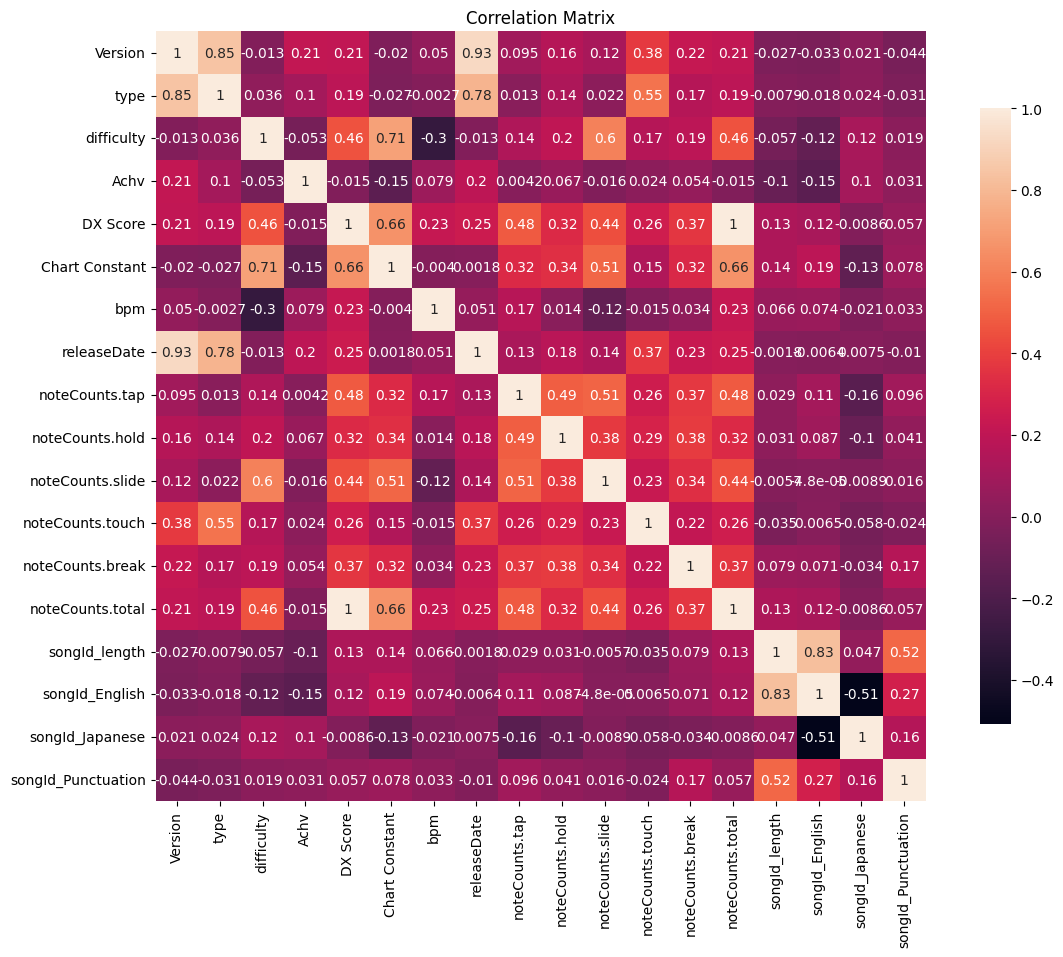

In [27]:
# Filter out numerical columns for correlation matrix
correlation_matrix = merged_df.select_dtypes(include=["number"]).corr()

fig = plt.figure(clear=True, figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix")
plt.show()

In [28]:
def correlation_rankings(
    corr_mat: pd.DataFrame, target_column: str, threshold: float = 0.95
):
    """Print all abs(correlation with anything) that exceeds a threshold"""
    output = []

    for col in corr_mat.columns:
        if col == target_column:
            continue

        strong_correlations = (
            corr_mat[col][corr_mat[col].abs() > threshold]
            .drop(col)
            .sort_values(ascending=False, key=lambda x: x.abs())
        )

        if not strong_correlations.empty:
            formatted_corrs: list = []
            for corr_col, value in strong_correlations.items():
                color: str = "bold green" if value > 0 else "bold red"
                formatted_corrs.append(f"[{color}]{corr_col} ({value:.2f})[/{color}]")

            corr_with_target = corr_mat.loc[col, target_column]
            correlations_str = ", ".join(formatted_corrs)

            header = "".join(
                [
                    f"[bold sky_blue1]{col} ({target_column}: {corr_with_target:.2f}, ",
                    f"count: {len(strong_correlations)}):[/bold sky_blue1]",
                ]
            )
            full_line = f"{header} [{correlations_str}]"

            output.append(full_line)

    output.sort(
        key=lambda x: float(x.split(f"({target_column}: ")[1].split(",")[0]),
        reverse=True,
    )
    if output:
        rich.print("\n".join(output))


correlation_rankings(correlation_matrix, target_column="Achv")

DX Score (Achv: -0.01, count: 1): [noteCounts.total (1.00)]
noteCounts.total (Achv: -0.01, count: 1): [DX Score (1.00)]

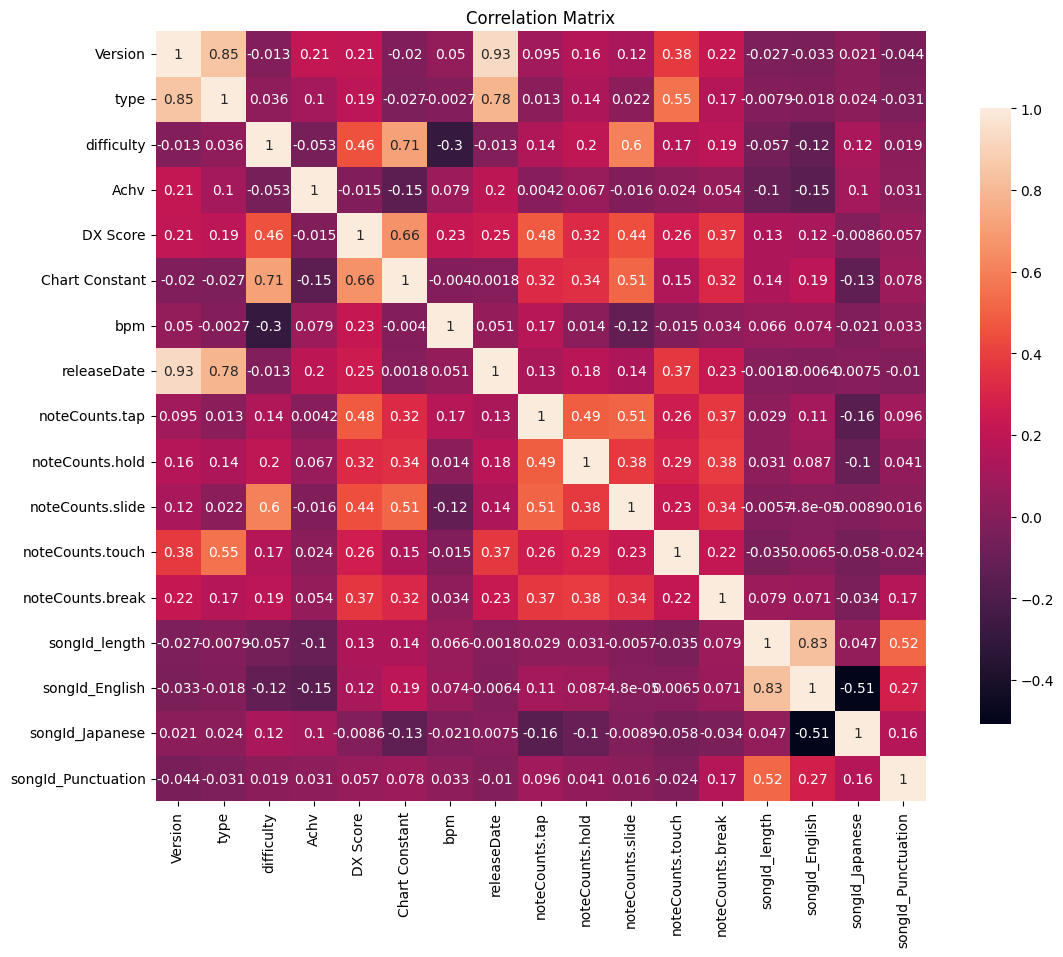

In [29]:
# Drop collinear columns
merged_df.drop(
    columns=[
        "noteCounts.total",
    ],
    inplace=True,
)

correlation_matrix = merged_df.select_dtypes(include=["number"]).corr()
correlation_rankings(correlation_matrix, target_column="Achv")

fig = plt.figure(clear=True, figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix")
plt.show()

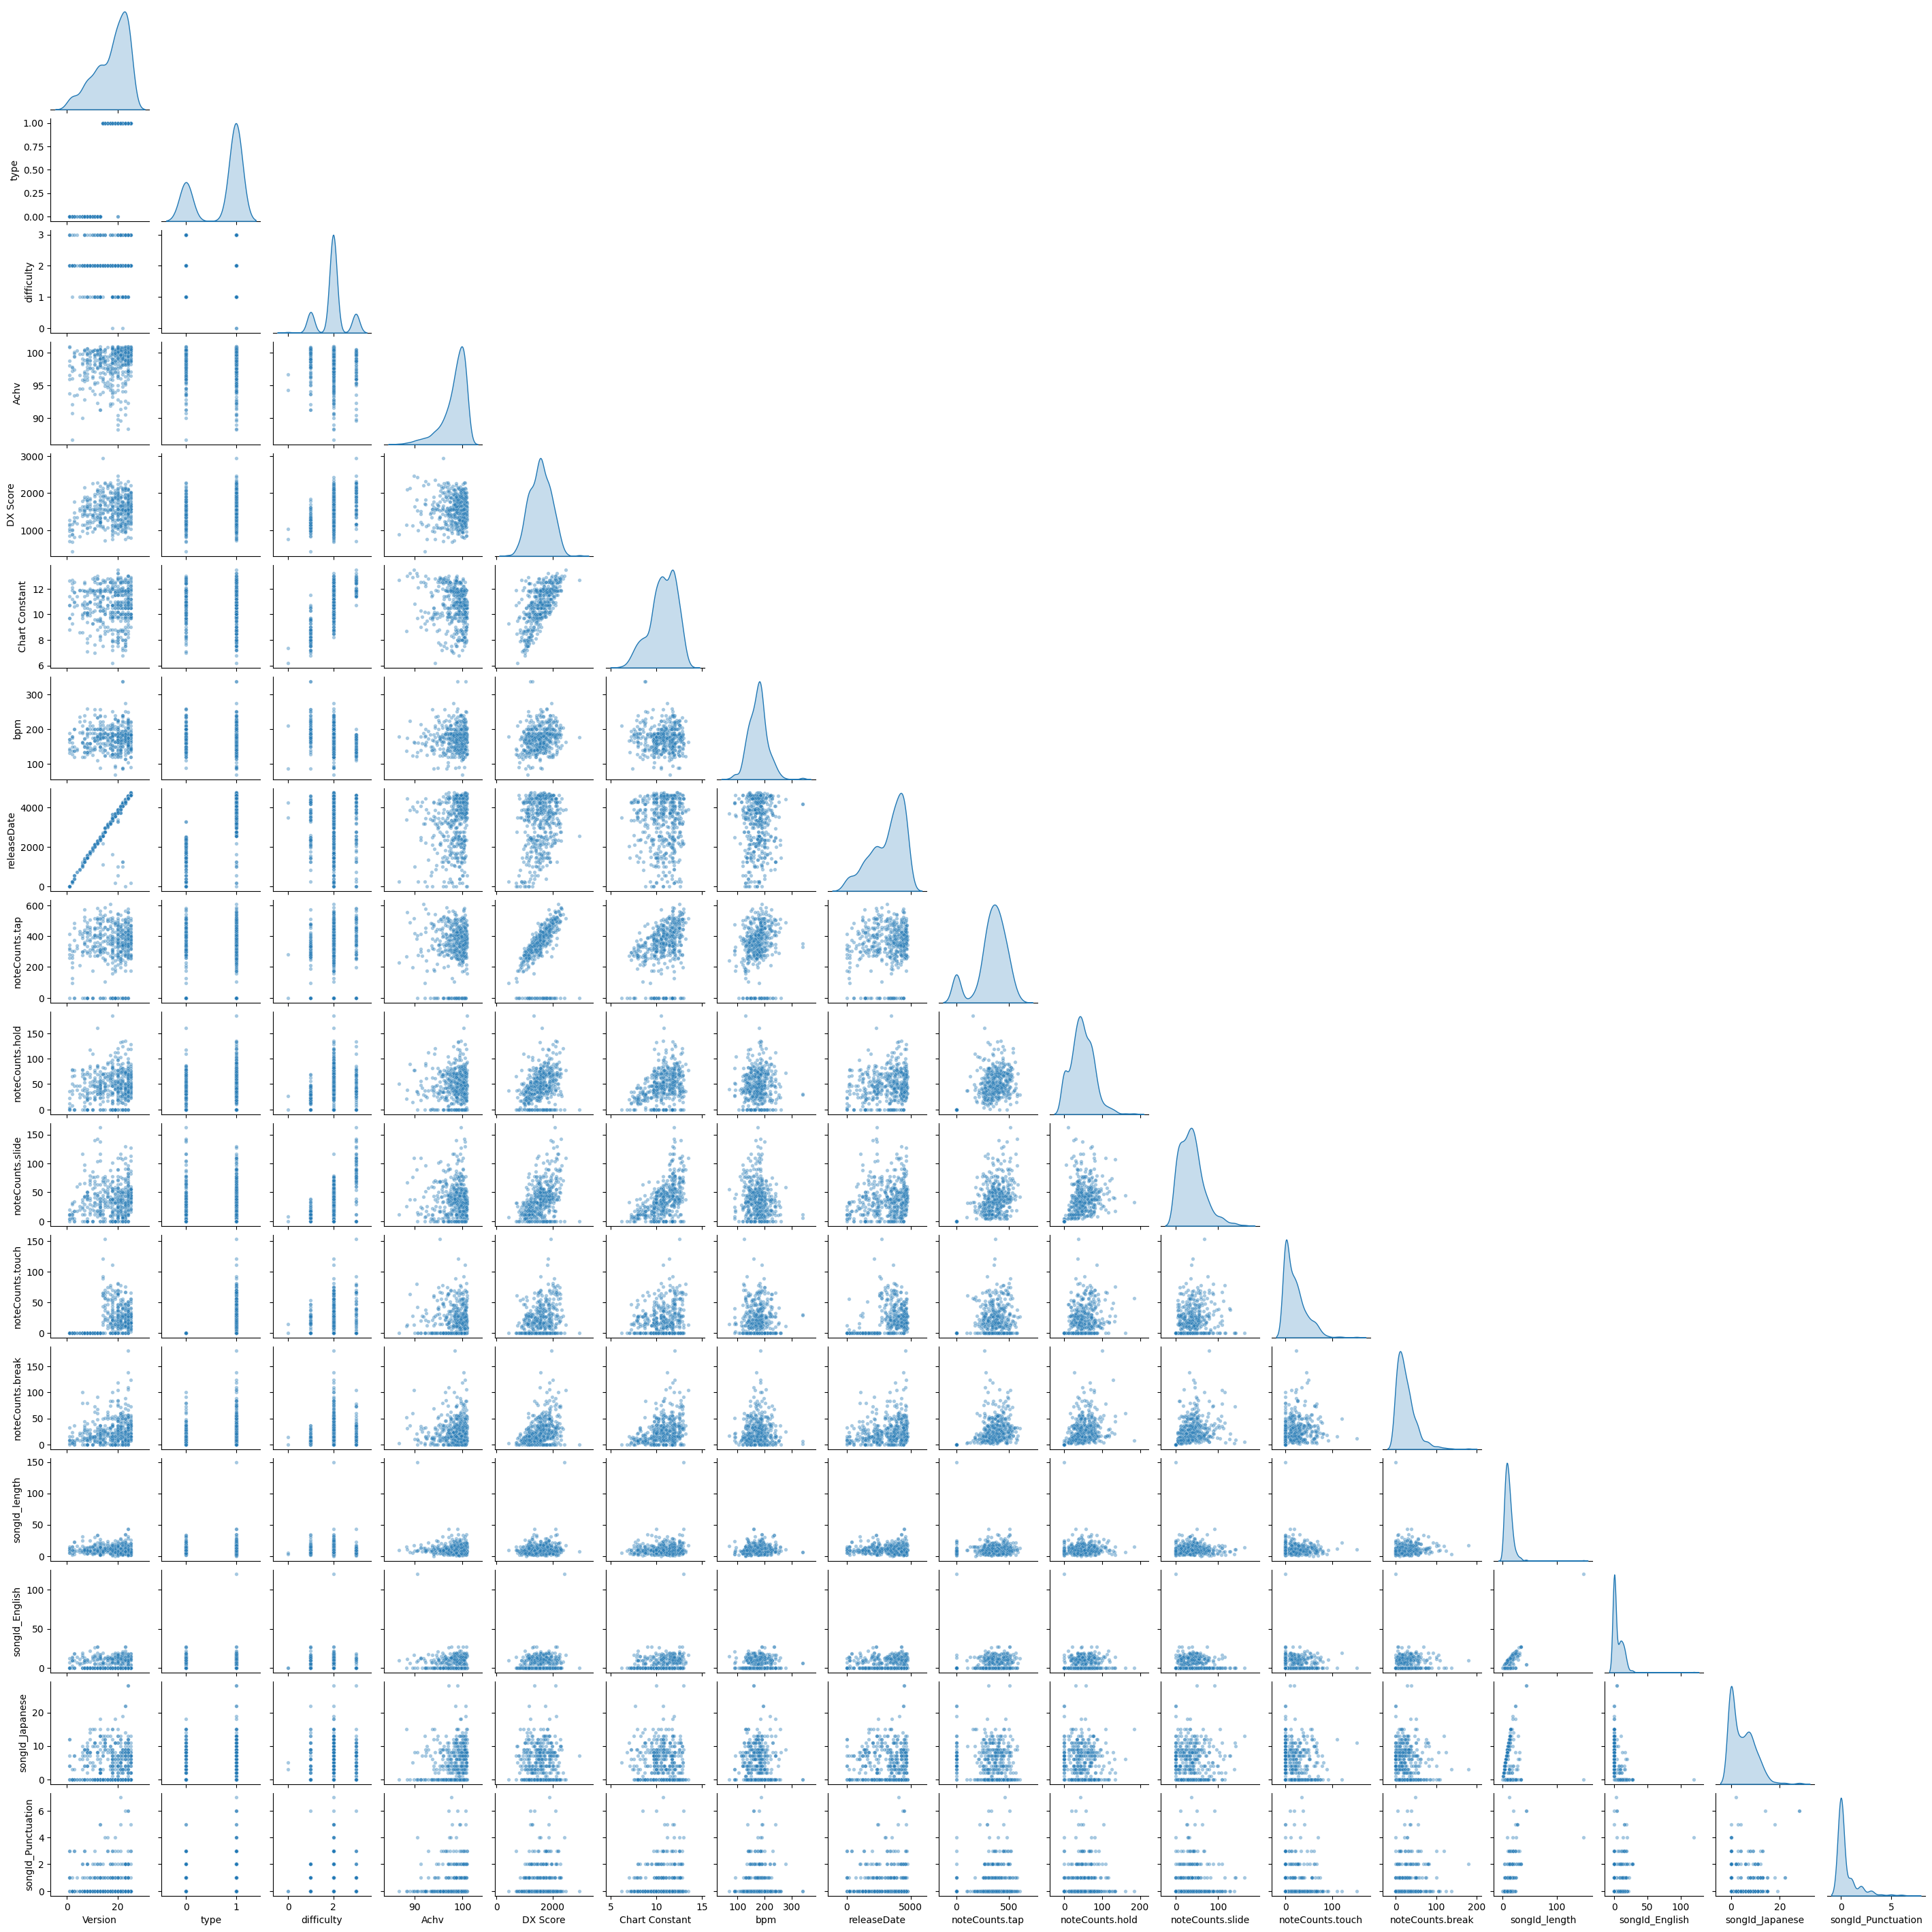

In [30]:
# Pairwise correlation with seaborn
sns.pairplot(
    merged_df,
    diag_kind="kde",
    plot_kws={"alpha": 0.4, "s": 15},
    corner=True,
    height=1.7,
)
plt.show()

Regression

In [31]:
print(merged_df.columns)

numerical_features = (
    merged_df.select_dtypes(include=["number"]).columns.drop("Achv").tolist()
)
categorical_features = ["Genre"]

drop_columns = [
    feature
    for feature in merged_df.columns
    if feature not in numerical_features + categorical_features + ["Achv", "Rank"]
]
print(f"Dropping columns: {drop_columns}")
merged_df.drop(
    columns=drop_columns,
    inplace=True,
)

merged_df.dropna(inplace=True)

Index(['songId', 'Genre', 'Version', 'type', 'difficulty', 'Level', 'Achv',
       'Rank', 'DX Score', 'Chart Constant', 'bpm', 'releaseDate',
       'noteCounts.tap', 'noteCounts.hold', 'noteCounts.slide',
       'noteCounts.touch', 'noteCounts.break', 'noteDesigner', 'songId_length',
       'songId_English', 'songId_Japanese', 'songId_Punctuation'],
      dtype='object')
Dropping columns: ['songId', 'Level', 'noteDesigner']


In [32]:
# merged_df.to_csv("maimai.cleaned.csv", index=False)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    merged_df[numerical_features + categorical_features],
    merged_df["Achv"],
    random_state=RANDOM_STATE,
    test_size=0.2,
    shuffle=True,
    stratify=merged_df["Rank"],
)

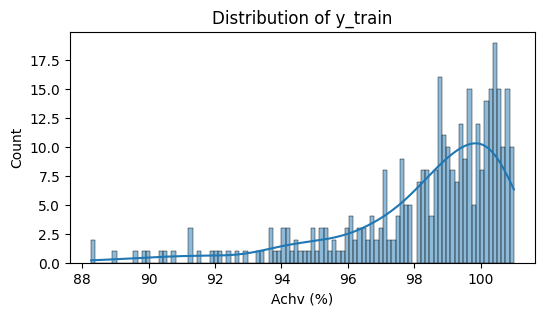

Achv Box-Cox Lambda: 27.166938238786194


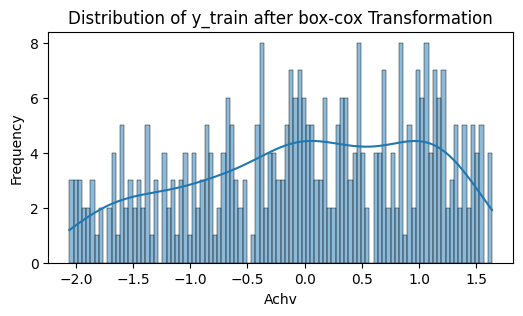

In [34]:
# Visualize distribution of Achv
plt.figure(figsize=(6, 3))
sns.histplot(y_train, bins=100, kde=True)
plt.title("Distribution of y_train")
plt.xlabel("Achv (%)")
plt.show()

TRANSFORM_ACHV = ["box-cox", "log", "none"][0]

if TRANSFORM_ACHV == "box-cox":
    # Convert non-linear Achv score to a (almost) gaussian like distribution
    y_train, achv_boxcox_lambda = stats.boxcox(y_train)
    y_test = stats.boxcox(y_test, lmbda=achv_boxcox_lambda)
    # The target variable now has crazy large values, so we normalize it
    scaler = StandardScaler()
    y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()
    print(f"Achv Box-Cox Lambda: {achv_boxcox_lambda}")
elif TRANSFORM_ACHV == "log":
    y_train = np.log(y_train / (101 - y_train))
    y_test = np.log(y_test / (101 - y_test))
else:
    pass

plt.figure(figsize=(6, 3))
sns.histplot(y_train, bins=100, kde=True)
plt.title(f"Distribution of y_train after {TRANSFORM_ACHV} Transformation")
plt.xlabel("Achv")
plt.ylabel("Frequency")
plt.show()


def Achv_inverse_transform(y_transformed):
    if TRANSFORM_ACHV == "box-cox":
        # Inverse Box-Cox transformation
        y = np.asarray(y_transformed).reshape(-1, 1)
        y = scaler.inverse_transform(y).flatten()
        y = scipy.special.inv_boxcox(y, achv_boxcox_lambda)
    elif TRANSFORM_ACHV == "log":
        y = 101 / (1 + np.exp(-y_transformed))
    else:
        y = y_transformed
    return y

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    (
                        "poly",
                        PolynomialFeatures(
                            degree=1, include_bias=False, interaction_only=False
                        ),
                    ),
                    ("scaler", StandardScaler()),
                ]
            ),
            numerical_features,
        ),
        (
            "cat",
            OneHotEncoder(
                sparse_output=False,
                handle_unknown="error",
                categories=[
                    merged_df[column].unique().tolist()
                    for column in categorical_features
                ],
            ),
            categorical_features,
        ),
    ]
)
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "regressor",
            ElasticNetCV(
                max_iter=10000,
                l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

pipeline.fit(X_train, y_train)
chosen_alpha = pipeline.named_steps["regressor"].alpha_
print("Chosen alpha:", chosen_alpha)

y_train_pred = pipeline.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_absolute_error(y_train, y_train_pred)
print("Train set performance:")
print(f"R^2 Score: {train_r2:.4f}")
print(f"Mean Absolute Error: {train_mse:.4f}")

y_test_pred = pipeline.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_absolute_error(y_test, y_test_pred)
print("Test set performance:")
print(f"R^2 Score: {test_r2:.4f}")
print(f"Mean Absolute Error: {test_mse:.4f}")

cat_encoder = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = (
    list(cat_feature_names)
    + pipeline.named_steps["preprocessor"]
    .named_transformers_["num"]
    .named_steps["poly"]
    .get_feature_names_out(numerical_features)
    .tolist()
)

regressor_step = pipeline.named_steps["regressor"]

results_df = pd.DataFrame(
    {
        "Feature": [all_feature_names[i] for i in range(len(all_feature_names))],
        "Coefficient": regressor_step.coef_,
    }
).sort_values(by="Coefficient", ascending=False)
print(results_df)

Chosen alpha: 0.02911091287642069
Train set performance:
R^2 Score: 0.0984
Mean Absolute Error: 0.7917
Test set performance:
R^2 Score: 0.1202
Mean Absolute Error: 0.7826
                     Feature  Coefficient
0               Genre_maimai     0.193399
8                 difficulty     0.089721
5        Genre_オンゲキ＆CHUNITHM     0.057176
15          noteCounts.slide     0.032245
6                    Version     0.021473
14           noteCounts.hold     0.019939
2   Genre_niconico＆VOCALOID™     0.013202
18             songId_length     0.000000
3            Genre_東方Project     0.000000
19            songId_English     0.000000
11                       bpm     0.000000
12               releaseDate    -0.000000
7                       type     0.000000
9                   DX Score     0.000000
20           songId_Japanese    -0.000000
21        songId_Punctuation    -0.000000
16          noteCounts.touch    -0.000000
17          noteCounts.break     0.000000
10            Chart Constant   

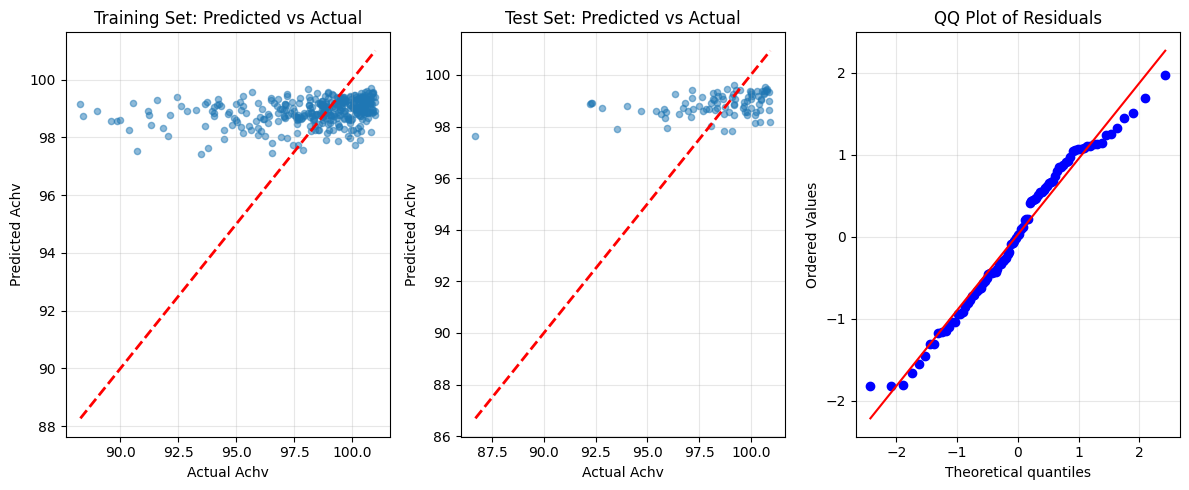

In [36]:
y_train_inv = Achv_inverse_transform(y_train)
y_train_pred_inv = Achv_inverse_transform(y_train_pred)
y_test_inv = Achv_inverse_transform(y_test)
y_test_pred_inv = Achv_inverse_transform(y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
# 1. Predicted vs Actual for training set
axes[0].scatter(y_train_inv, y_train_pred_inv, alpha=0.5, s=20)
axes[0].plot(
    [y_train_inv.min(), y_train_inv.max()],
    [y_train_inv.min(), y_train_inv.max()],
    "r--",
    lw=2,
)
axes[0].set_xlabel("Actual Achv")
axes[0].set_ylabel("Predicted Achv")
axes[0].set_title("Training Set: Predicted vs Actual")
axes[0].grid(True, alpha=0.3)

# 2. Predicted vs Actual for test set
axes[1].scatter(y_test_inv, y_test_pred_inv, alpha=0.5, s=20)
axes[1].plot(
    [y_test_inv.min(), y_test_inv.max()],
    [y_test_inv.min(), y_test_inv.max()],
    "r--",
    lw=2,
)
axes[1].set_xlabel("Actual Achv")
axes[1].set_ylabel("Predicted Achv")
axes[1].set_title("Test Set: Predicted vs Actual")
axes[1].grid(True, alpha=0.3)

# 3. Residual QQ plot
residuals = y_test - y_test_pred
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title("QQ Plot of Residuals")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        (
            "cat",
            OneHotEncoder(
                sparse_output=True,
                handle_unknown="error",
                categories=[
                    merged_df[column].unique().tolist()
                    for column in categorical_features
                ],
            ),
            categorical_features,
        ),
    ]
)
pipeline_rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor_rf),
        (
            "rfr",
            RandomForestRegressor(
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)
param_grid = {
    "rfr__max_depth": np.arange(3, 20, 1),
    "rfr__min_samples_leaf": np.arange(1, 50, 1),
    "rfr__ccp_alpha": np.arange(0, 0.04, 0.001),
}

grid_search = RandomizedSearchCV(
    pipeline_rf,
    param_grid,
    scoring="r2",
    n_jobs=-1,
    verbose=10,
    random_state=RANDOM_STATE,
    n_iter=100,
)

grid_search.fit(X_train, y_train)
pipeline_rf = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV MAE: {-grid_search.best_score_:.4f}")
print(f"Best CV R^2: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters: {'rfr__min_samples_leaf': np.int64(3), 'rfr__max_depth': np.int64(7), 'rfr__ccp_alpha': np.float64(0.032)}
Best CV MAE: -0.1173
Best CV R^2: 0.1173


In [38]:
y_train_pred_rf = pipeline_rf.predict(X_train)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
train_mse_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_mse_rf_transformed = mean_absolute_error(
    Achv_inverse_transform(y_train), Achv_inverse_transform(y_train_pred_rf)
)
print("Train set performance:")
print(f"R^2 Score: {train_r2_rf:.4f}")
print(f"Mean Absolute Error: {train_mse_rf:.4f}")
print(f"Mean Absolute Error (Inverse Transformed): {train_mse_rf_transformed:.4f}")

y_test_pred_rf = pipeline_rf.predict(X_test)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
test_mse_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_mse_rf_transformed = mean_absolute_error(
    Achv_inverse_transform(y_test), Achv_inverse_transform(y_test_pred_rf)
)
print("Test set performance:")
print(f"R^2 Score: {test_r2_rf:.4f}")
print(f"Mean Absolute Error: {test_mse_rf:.4f}")
print(f"Mean Absolute Error (Inverse Transformed): {test_mse_rf_transformed:.4f}")

Train set performance:
R^2 Score: 0.3372
Mean Absolute Error: 0.6907
Mean Absolute Error (Inverse Transformed): 1.5204
Test set performance:
R^2 Score: 0.1988
Mean Absolute Error: 0.7317
Mean Absolute Error (Inverse Transformed): 1.5414


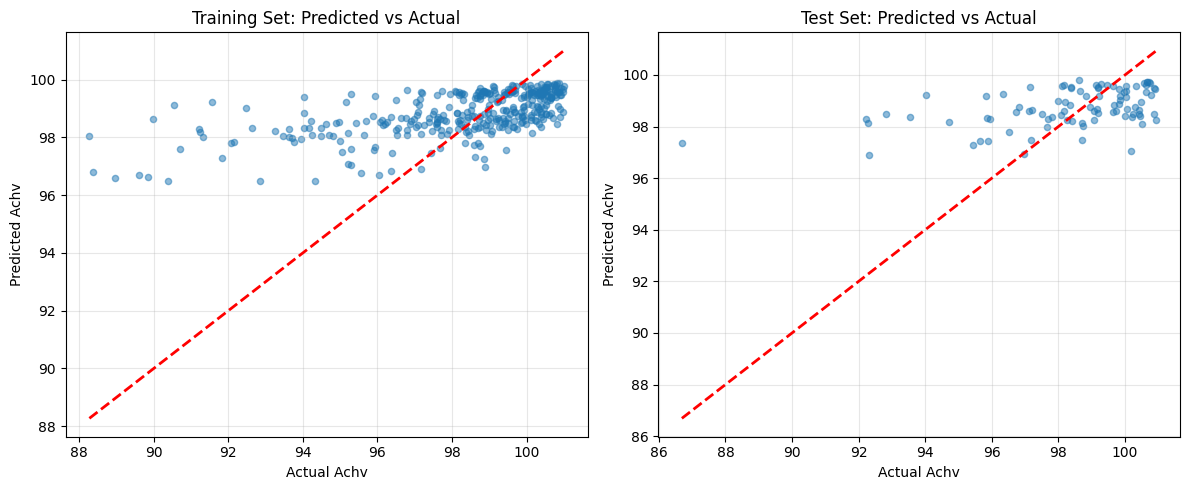

In [39]:
y_train_inv_rf = Achv_inverse_transform(y_train)
y_train_pred_inv_rf = Achv_inverse_transform(y_train_pred_rf)
y_test_inv_rf = Achv_inverse_transform(y_test)
y_test_pred_inv_rf = Achv_inverse_transform(y_test_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# 1. Predicted vs Actual for training set
axes[0].scatter(y_train_inv_rf, y_train_pred_inv_rf, alpha=0.5, s=20)
axes[0].plot(
    [y_train_inv_rf.min(), y_train_inv_rf.max()],
    [y_train_inv_rf.min(), y_train_inv_rf.max()],
    "r--",
    lw=2,
)
axes[0].set_xlabel("Actual Achv")
axes[0].set_ylabel("Predicted Achv")
axes[0].set_title("Training Set: Predicted vs Actual")
axes[0].grid(True, alpha=0.3)

# 2. Predicted vs Actual for test set
axes[1].scatter(y_test_inv_rf, y_test_pred_inv_rf, alpha=0.5, s=20)
axes[1].plot(
    [y_test_inv_rf.min(), y_test_inv_rf.max()],
    [y_test_inv_rf.min(), y_test_inv_rf.max()],
    "r--",
    lw=2,
)
axes[1].set_xlabel("Actual Achv")
axes[1].set_ylabel("Predicted Achv")
axes[1].set_title("Test Set: Predicted vs Actual")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

,Feature,Importance
4,Chart Constant,0.344026
6,releaseDate,0.291948
3,DX Score,0.059276
0,Version,0.053285
9,noteCounts.slide,0.049269
5,bpm,0.034832
13,songId_English,0.031518
7,noteCounts.tap,0.030600
8,noteCounts.hold,0.023531
11,noteCounts.break,0.020954


C:\Users\123er\AppData\Local\Temp\ipykernel_16232\2443073960.py:23: UserWarning: Glyph 65286 (\N{FULLWIDTH AMPERSAND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\123er\AppData\Local\Temp\ipykernel_16232\2443073960.py:23: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\123er\AppData\Local\Temp\ipykernel_16232\2443073960.py:23: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\123er\AppData\Local\Temp\ipykernel_16232\2443073960.py:23: UserWarning: Glyph 12466 (\N{KATAKANA LETTER GE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\123er\AppData\Local\Temp\ipykernel_16232\2443073960.py:23: UserWarning: Glyph 12461 (\N{KATAKANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\123er\AppData\Local\Temp\ipykernel_16232\2443073960.py:23: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing fr

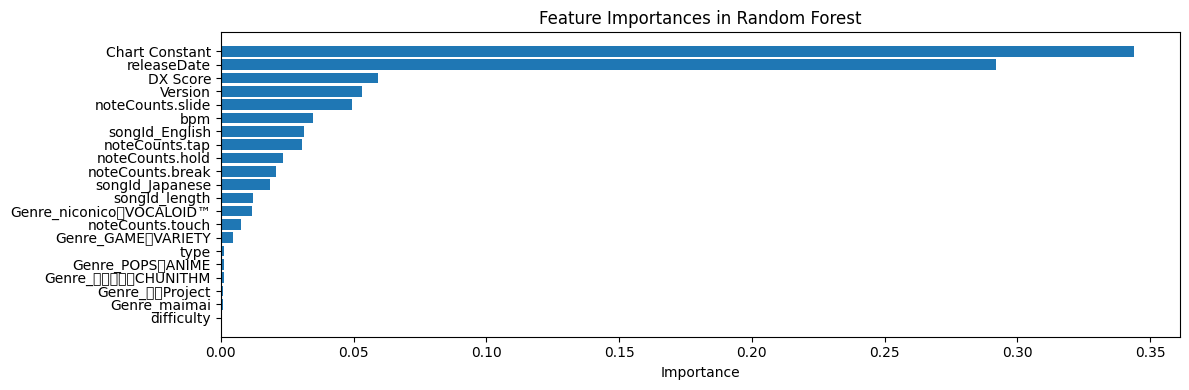

In [40]:
rf_features_step = pipeline_rf.named_steps["preprocessor"].named_transformers_["num"]
rf_numeric_feature_names = rf_features_step.get_feature_names_out(numerical_features)

cat_encoder_rf = pipeline_rf.named_steps["preprocessor"].named_transformers_["cat"]
cat_feature_names_rf = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names_rf = list(rf_numeric_feature_names) + list(cat_feature_names_rf)
rf_model = pipeline_rf.named_steps["rfr"]

importance_df = pd.DataFrame(
    {"Feature": all_feature_names_rf, "Importance": rf_model.feature_importances_}
).sort_values(by="Importance", ascending=False)
useful_features = importance_df[importance_df["Importance"] > 0]
display(useful_features)

fig, ax = plt.subplots(figsize=(12, 4))
ax.barh(range(len(useful_features)), useful_features["Importance"])
ax.set_yticks(range(len(useful_features)))
ax.set_yticklabels(useful_features["Feature"])
ax.set_xlabel("Importance")
ax.set_title("Feature Importances in Random Forest")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [41]:
# Show the test set predictions and actual scores
test_results_df = pd.DataFrame(
    {
        "Actual Achv": Achv_inverse_transform(y_test),
        "Predicted Achv (ElasticNet)": Achv_inverse_transform(y_test_pred),
        "Predicted Achv (RandomForest)": Achv_inverse_transform(y_test_pred_rf),
    }
)
display(test_results_df)

,Actual Achv,Predicted Achv (ElasticNet),Predicted Achv (RandomForest)
0,98.10,98.929967,99.581971
1,95.90,98.578086,97.429513
2,98.72,97.840304,97.493313
3,100.76,99.445556,99.673339
4,98.94,98.547492,98.776691
...,...,...,...
86,95.82,98.668193,99.172919
87,99.22,99.059156,99.170527
88,99.81,98.460661,99.463648
89,99.29,99.411395,99.635862
